# Import Libraries

In [1]:
import FaultAnalysisDropout.pNN_FA as pNN
from configuration import *
from utils import *
import sys
import os
from pathlib import Path
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import heapq

# Initialization

In [2]:
sys.path.append(os.getcwd())
sys.path.append(str(Path(os.getcwd()).parent))
if not os.path.exists('../experiments/FaultAnalysis/evaluation/'):
    os.makedirs('../experiments/FaultAnalysis/evaluation/')

args = parser.parse_args([])
args = FormulateArgs(args)

args.DATASET = 0
args.SEED = 6
args.e_train = 0.0
args.N_fault = 1
args.e_fault = 0.0

args.dropout = 0.0
args.fault_ratio = 0.0


# Load Model and Dataset Prepration

Update the args

In [ ]:
valid_loader, datainfo = GetDataLoader(args, 'valid', path='../dataset/')
test_loader, datainfo = GetDataLoader(args, 'test',  path='../dataset/')
pprint.pprint(datainfo)

for x, y in valid_loader:
    X_valid, y_valid = x.to(args.DEVICE), y.to(args.DEVICE)
for x, y in test_loader:
    X_test, y_test = x.to(args.DEVICE), y.to(args.DEVICE)

In [ ]:
# Load the Model
topology = [datainfo['N_feature']] + args.hidden + [datainfo['N_class']]

tmp_pnn = pNN.pNN(topology, args).to(args.DEVICE)

best_acc = 0.0
pnn = pNN.pNN(topology, args).to(args.DEVICE)
for seed in range(10):
        
        args.SEED = seed

        modelname = f"data_{args.DATASET:02d}_{datainfo['dataname']}_seed_{
                args.SEED:02d}_epsilon_{args.e_train}_dropout_{args.dropout}_fault_ratio_{args.fault_ratio}.model"
        trained_model = torch.load(f'../trained_models/tanh_0_FaultAnalysisNormal/models/{modelname}')

        for i, j in zip(trained_model.model, tmp_pnn.model):
                j.theta_.data = i.theta_.data.clone()
                
        tmp_pnn.UpdateFault(N_fault=args.N_fault, e_fault=args.e_fault)
        tmp_pnn.UpdateArgs(args)
        
        pred_valid = tmp_pnn(X_valid)[0,0,:,:]
        base_acc_valid = (torch.argmax(pred_valid, dim=1) ==
                                y_valid).sum() / y_valid.numel()
        print(f"Seed: {seed}, Accuracy: {base_acc_valid}")
        if best_acc < base_acc_valid:
            best_acc = base_acc_valid
            best_seed = seed
            pnn = pNN.pNN(topology, args).to(args.DEVICE)
            for i, j in zip(trained_model.model, pnn.model):
                j.theta_.data = i.theta_.data.clone()
                pnn.UpdateFault(N_fault=args.N_fault, e_fault=args.e_fault)
                pnn.UpdateArgs(args)

In [ ]:
pred_valid = pnn(X_valid)[0,0,:,:]
base_acc_valid = (torch.argmax(pred_valid, dim=1) ==
                                y_valid).sum() / y_valid.numel()
base_acc_valid

# Analysis

In [ ]:
pred_valid = pnn(X_valid)[0,0,:,:]
base_acc_valid = (torch.argmax(pred_valid, dim=1) ==
                         y_valid).sum() / y_valid.numel()
base_acc_valid

In [ ]:
topology

## Define Methods

In [8]:
def act_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=1, num_fault_sub_type=[]):
    # type of fault: 0 - theta, 1 - act, 2 - neg
    # dict_fault_sub_type = {i: [] for i in range(num_fault_sub_type)}
    dict_fault_sub_type = {i: [] for i in num_fault_sub_type}
    list_sample_fault = []
    for layer_i, num_neuron in enumerate(topology[1:]):
        # list of faulty layers starting from 0
        faulty_layer_list=[layer_i]
        for neuron_i in range(num_neuron):
            # index of element within the layer
            indice_to_modify=neuron_i
            # for sub_fault_i in range(num_fault_sub_type):
            for sub_fault_i in num_fault_sub_type:
                # type of fault within the non-linear circuit
                fault_type_non_linear=sub_fault_i
                
                sample_fault = (faulty_layer_list, type_fault, indice_to_modify, fault_type_non_linear)
                list_sample_fault.append(sample_fault)
                
                pred_valid = pnn(X_valid, faulty_layer_list=faulty_layer_list, type_fault=type_fault, 
                                indice_to_modify=indice_to_modify, fault_type_non_linear=fault_type_non_linear)[0,0,:,:]

                acc_valid = (torch.argmax(pred_valid, dim=1) ==
                                        y_valid).sum() / y_valid.numel()
                drop_acc = base_acc_valid - acc_valid
                dict_fault_sub_type[sub_fault_i].append(drop_acc)
                # print(f'layer: {layer_i}, neuron: {neuron_i}, sub_fault: {sub_fault_i}, drop_acc: {drop_acc}')
    return dict_fault_sub_type, list_sample_fault


def theta_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=0, num_fault_sub_type=2):
    # type of fault: 0 - theta, 1 - act, 2 - neg
    dict_fault_sub_type = {i: [] for i in range(num_fault_sub_type)}
    list_sample_fault = []
    for layer_i, _ in enumerate(topology[1:]):
        # list of faulty layers starting from 0
        faulty_layer_list=[layer_i]
        for connection_i in range(torch.prod(torch.tensor(pnn.model[layer_i].theta_.shape))):
            # index of element within the layer
            indice_to_modify=connection_i
            for sub_fault_i in range(num_fault_sub_type):
                # type of fault within the non-linear circuit
                fault_type_non_linear=sub_fault_i
                
                sample_fault = (faulty_layer_list, type_fault, indice_to_modify, fault_type_non_linear)
                list_sample_fault.append(sample_fault)
                
                pred_valid = pnn(X_valid, faulty_layer_list=faulty_layer_list, type_fault=type_fault, 
                                indice_to_modify=indice_to_modify, fault_type_non_linear=fault_type_non_linear)[0,0,:,:]

                acc_valid = (torch.argmax(pred_valid, dim=1) ==
                                        y_valid).sum() / y_valid.numel()
                drop_acc = base_acc_valid - acc_valid
                dict_fault_sub_type[sub_fault_i].append(drop_acc)
                # print(f'layer: {layer_i}, connection: {connection_i}, sub_fault: {sub_fault_i}, drop_acc: {drop_acc}')
    return dict_fault_sub_type, list_sample_fault


def inv_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=2, num_fault_sub_type=[]):
    # type of fault: 0 - theta, 1 - act, 2 - neg
    dict_fault_sub_type = {i: [] for i in num_fault_sub_type}
    list_sample_fault = []
    for layer_i, _ in enumerate(topology[1:]):
        # list of faulty layers starting from 0
        faulty_layer_list=[layer_i]
        for input_i in range(torch.tensor(pnn.model[layer_i].theta_.shape[0])):
            # index of element within the layer
            indice_to_modify=input_i
            for sub_fault_i in num_fault_sub_type:
                # type of fault within the non-linear circuit
                fault_type_non_linear=sub_fault_i
                
                sample_fault = (faulty_layer_list, type_fault, indice_to_modify, fault_type_non_linear)
                list_sample_fault.append(sample_fault)
                
                pred_valid = pnn(X_valid, faulty_layer_list=faulty_layer_list, type_fault=type_fault, 
                                indice_to_modify=indice_to_modify, fault_type_non_linear=fault_type_non_linear)[0,0,:,:]

                acc_valid = (torch.argmax(pred_valid, dim=1) ==
                                        y_valid).sum() / y_valid.numel()
                drop_acc = base_acc_valid - acc_valid
                dict_fault_sub_type[sub_fault_i].append(drop_acc)
                # print(f'layer: {layer_i}, connection: {input_i}, sub_fault: {sub_fault_i}, drop_acc: {drop_acc}')
    return dict_fault_sub_type, list_sample_fault

## Plot Heatmap

In [ ]:
dict_fault_sub_type, act_list_fault_sample = act_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=1, num_fault_sub_type=range(12))

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:]) ) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([dict_fault_sub_type[i] for i in dict_fault_sub_type.keys()]) * 100)

# Plot the heatmap using Seaborn for annotations
# plt.figure(figsize=(12, 8))
# Create a figure and axis
fig, axs = plt.subplots(3, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 1, 1]})

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[0], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[0].set_title("Impact of Tanh Faults on Accuracy Across Layers and Neurons", fontsize=14)
axs[0].set_xlabel("Layer-Neuron", fontsize=12)
axs[0].set_ylabel("Tanh Fault Types", fontsize=12)
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=45, ha="right")

# -----------------------------------------

dict_fault_sub_type, inv_list_fault_sample = inv_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=2, num_fault_sub_type=range(18))

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-I{j}" for i in range(len(topology[:-1]) ) for j in range(pnn.model[i].theta_.shape[0])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"INV Fault {i}" for i in dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([dict_fault_sub_type[i] for i in dict_fault_sub_type.keys()]) * 100)

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[1], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[1].set_title("Impact of Invertor Faults on Accuracy Across Layers and Inputs", fontsize=14)
axs[1].set_xlabel("Layer-Inputs", fontsize=12)
axs[1].set_ylabel("Invertor Fault Types", fontsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=45, ha="right")

# -----------------------------------------

dict_fault_sub_type, theta_list_fault_sample = theta_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=0, num_fault_sub_type=2)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-C{j}" for i in range(len(topology[1:]) ) for j in range(torch.prod(torch.tensor(pnn.model[i].theta_.shape)))]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Theta Fault {i}" for i in dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([dict_fault_sub_type[i] for i in dict_fault_sub_type.keys()]) * 100)

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[2], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[2].set_title("Impact of Theta Faults on Accuracy Across Layers and Connections", fontsize=14)
axs[2].set_xlabel("Layer-Connection", fontsize=12)
axs[2].set_ylabel("Theta Fault Types", fontsize=12)
axs[2].set_xticklabels(axs[2].get_xticklabels(),rotation=45, ha="right")


plt.tight_layout()
plt.show()



## Plot Tanh Heatmap

In [ ]:
# after clustering
# num_fault_sub_type = [2, 6, 12, 0, 1, 3, 4] 
num_fault_sub_type = np.array([3, 11, 5, 0, 2, 10, 1]) + 1
cluster_dict_fault_sub_type, cluster_act_list_fault_sample = act_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=1, num_fault_sub_type=num_fault_sub_type)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:]) ) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in cluster_dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([cluster_dict_fault_sub_type[i] for i in cluster_dict_fault_sub_type.keys()]) * 100)

# Plot the heatmap using Seaborn for annotations
# plt.figure(figsize=(12, 8))
# Create a figure and axis
fig, axs = plt.subplots(2, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 1]})

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[0], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[0].set_title("(After Clustering) Impact of Tanh Faults on Accuracy Across Layers and Neurons", fontsize=14)
axs[0].set_xlabel("Layer-Neuron", fontsize=12)
axs[0].set_ylabel("Tanh Fault Types", fontsize=12)
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=45, ha="right")

# -----------------------------------------

# before clustering
num_fault_sub_type = range(1, 13)
all_dict_fault_sub_type, all_act_list_fault_sample = act_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=1, num_fault_sub_type=num_fault_sub_type)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:]) ) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in all_dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([all_dict_fault_sub_type[i] for i in all_dict_fault_sub_type.keys()]) * 100)

# Plot the heatmap using Seaborn for annotations
# plt.figure(figsize=(12, 8))
# Create a figure and axis
# fig, axs = plt.subplots(3, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 1, 1]})

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[1], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[1].set_title("(Before Clustering) Impact of Tanh Faults on Accuracy Across Layers and Neurons", fontsize=14)
axs[1].set_xlabel("Layer-Neuron", fontsize=12)
axs[1].set_ylabel("Tanh Fault Types", fontsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=45, ha="right")

In [ ]:
len(all_act_list_fault_sample), len(cluster_act_list_fault_sample)

In [12]:
def act_get_output_differences(pnn, test_inputs, topology, type_fault=1, num_fault_sub_type=[]):
    """
    Calculate the average output differences caused by faults for each layer and neuron.
    
    Args:
        pnn: The neural network model.
        test_inputs: A batch of test inputs (tensor).
        topology: List of layer sizes in the network.
        type_fault: Type of fault (0 - theta, 1 - act, 2 - neg).
        num_fault_sub_type: List of fault sub-types to analyze.

    Returns:
        dict_fault_sub_type: A dictionary mapping fault sub-types to their impact across neurons.
        list_sample_fault: A list of all fault configurations tested.
    """
    # Dictionary to store the impact for each fault sub-type
    dict_fault_sub_type = {i: [] for i in num_fault_sub_type}
    list_sample_fault = []
    active_faults = []
    inactive_faults = []

    # Loop over all layers and neurons
    for layer_i, num_neurons in enumerate(topology[1:]):  # Skip input layer
        # List of faulty layers starting from 0
        faulty_layer_list = [layer_i]

        for neuron_i in range(num_neurons):  # Loop through neurons in the layer
            indice_to_modify = neuron_i

            for sub_fault_i in num_fault_sub_type:  # Loop through fault sub-types
                fault_type_non_linear = sub_fault_i

                # Create a fault configuration
                sample_fault = (faulty_layer_list, type_fault, indice_to_modify, fault_type_non_linear)
                list_sample_fault.append(sample_fault)

                # Compute fault-free outputs
                output_fault_free = pnn(test_inputs)[0, 0, :, :]

                # Compute faulty outputs
                output_faulty = pnn(test_inputs, faulty_layer_list=faulty_layer_list, 
                                    type_fault=type_fault, 
                                    indice_to_modify=indice_to_modify, 
                                    fault_type_non_linear=fault_type_non_linear)[0, 0, :, :]

                # Calculate the average output difference for this fault
                # diff = torch.mean(torch.norm(output_faulty - output_fault_free, dim=1)).item()
                diff = torch.nn.functional.mse_loss(output_faulty, output_fault_free).item()

                # Store the impact for this fault sub-type
                dict_fault_sub_type[sub_fault_i].append(diff)

                # Print for debugging
                # print(f"Layer: {layer_i}, Neuron: {neuron_i}, Sub-Fault: {sub_fault_i}, Avg Difference: {diff}")
                
                # Sum differences over all test inputs for the fault
                sum_diff = torch.sum(torch.abs(output_faulty - output_fault_free)).item()

                # Classify faults as active or inactive
                if sum_diff > 0:
                    active_faults.append(sample_fault)
                else:
                    inactive_faults.append(sample_fault)

    return dict_fault_sub_type, list_sample_fault, active_faults, inactive_faults


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm

# num_fault_sub_type = [2, 6, 12, 0, 1, 3, 4]
num_fault_sub_type = np.array([3, 11, 5, 0, 2, 10, 1]) + 1
test_input_dim = topology[0]
test_inputs = torch.rand(1000, test_input_dim)  # Adjust input dimension 
    
dict_fault_sub_type, list_act_sample_fault, act_active_faults, act_inactive_faults = act_get_output_differences(
    pnn=pnn,
    test_inputs=test_inputs,
    topology=topology,
    type_fault=1,
    num_fault_sub_type=num_fault_sub_type)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:])) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in dict_fault_sub_type.keys()]

# Simulate output difference data (rows: faults, columns: layer-neurons)
output_differences = np.array([dict_fault_sub_type[i] for i in dict_fault_sub_type.keys()])

# Apply normalization to make zero values distinctly green
norm = TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=np.max(output_differences))

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(
    output_differences,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn_r",  # Diverging colormap
    xticklabels=layers_neurons,
    yticklabels=tanh_faults,
    cbar_kws={'label': 'Output Difference (%)'},
    norm=norm  # Use TwoSlopeNorm for distinct green at zero
)

# Add titles and labels
plt.title("(After Clustering) Impact of Tanh Faults on Output Differences Across Layers and Neurons", fontsize=16)
plt.xlabel("Layer-Neuron", fontsize=14)
plt.ylabel("Tanh Fault Types", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust layout to fit labels properly
plt.tight_layout()
plt.show()

In [ ]:
len(all_act_list_fault_sample), len(act_active_faults), len(act_inactive_faults)

In [ ]:
act_active_faults

## Plot Invetor Heatmap

In [ ]:
# after clustering
num_fault_sub_type = np.array([0, 4, 1, 16, 2, 15, 8, 11, 6]) + 1
cluster_dict_fault_sub_type, cluster_inv_list_fault_sample = inv_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=2, num_fault_sub_type=num_fault_sub_type)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:]) ) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in cluster_dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([cluster_dict_fault_sub_type[i] for i in cluster_dict_fault_sub_type.keys()]) * 100)

# Plot the heatmap using Seaborn for annotations
# plt.figure(figsize=(12, 8))
# Create a figure and axis
fig, axs = plt.subplots(2, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 1]})

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[0], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[0].set_title("(After Clustering) Impact of Tanh Faults on Accuracy Across Layers and Neurons", fontsize=14)
axs[0].set_xlabel("Layer-Neuron", fontsize=12)
axs[0].set_ylabel("Tanh Fault Types", fontsize=12)
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=45, ha="right")

# -----------------------------------------

# before clustering
num_fault_sub_type = range(1, 19)
all_dict_fault_sub_type, all_inv_list_fault_sample = inv_get_drop_acc(pnn, X_valid, y_valid, base_acc_valid, type_fault=2, num_fault_sub_type=num_fault_sub_type)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:]) ) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in all_dict_fault_sub_type.keys()]

# Simulate accuracy drop data (rows: faults, columns: layer-neurons)
accuracy_drop = np.int16(np.array([all_dict_fault_sub_type[i] for i in all_dict_fault_sub_type.keys()]) * 100)

# Plot the heatmap using Seaborn for annotations
# plt.figure(figsize=(12, 8))
# Create a figure and axis
# fig, axs = plt.subplots(3, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 1, 1]})

sns.heatmap(accuracy_drop, annot=True, fmt="d", cmap="RdYlGn_r", ax=axs[1], cbar_kws={'label': 'Accuracy Drop (%)'}, xticklabels=layers_neurons, yticklabels=tanh_faults)
axs[1].set_title("(Before Clustering) Impact of Tanh Faults on Accuracy Across Layers and Neurons", fontsize=14)
axs[1].set_xlabel("Layer-Neuron", fontsize=12)
axs[1].set_ylabel("Tanh Fault Types", fontsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=45, ha="right")

In [ ]:
len(all_inv_list_fault_sample), len(cluster_inv_list_fault_sample)

In [18]:
def inv_get_output_differences(pnn, test_inputs, topology, type_fault=1, num_fault_sub_type=[]):
    """
    Calculate the average output differences caused by faults for each layer and neuron.
    
    Args:
        pnn: The neural network model.
        test_inputs: A batch of test inputs (tensor).
        topology: List of layer sizes in the network.
        type_fault: Type of fault (0 - theta, 1 - act, 2 - neg).
        num_fault_sub_type: List of fault sub-types to analyze.

    Returns:
        dict_fault_sub_type: A dictionary mapping fault sub-types to their impact across neurons.
        list_sample_fault: A list of all fault configurations tested.
    """
    # Dictionary to store the impact for each fault sub-type
    dict_fault_sub_type = {i: [] for i in num_fault_sub_type}
    list_sample_fault = []
    active_faults = []
    inactive_faults = []
    

    # Loop over all layers and neurons
    for layer_i, num_neurons in enumerate(topology[1:]):  # Skip input layer
        # List of faulty layers starting from 0
        faulty_layer_list = [layer_i]

        for input_i in range(torch.tensor(pnn.model[layer_i].theta_.shape[0])):
            # index of element within the layer
            indice_to_modify=input_i

            for sub_fault_i in num_fault_sub_type:
                # type of fault within the non-linear circuit
                fault_type_non_linear=sub_fault_i

                # Create a fault configuration
                sample_fault = (faulty_layer_list, type_fault, indice_to_modify, fault_type_non_linear)
                list_sample_fault.append(sample_fault)

                # Compute fault-free outputs
                output_fault_free = pnn(test_inputs)[0, 0, :, :]

                # Compute faulty outputs
                output_faulty = pnn(test_inputs, faulty_layer_list=faulty_layer_list, 
                                    type_fault=type_fault, 
                                    indice_to_modify=indice_to_modify, 
                                    fault_type_non_linear=fault_type_non_linear)[0, 0, :, :]

                # Calculate the average output difference for this fault
                # diff = torch.mean(torch.norm(output_faulty - output_fault_free, dim=1)).item()
                diff = torch.nn.functional.mse_loss(output_faulty, output_fault_free).item()

                # Store the impact for this fault sub-type
                dict_fault_sub_type[sub_fault_i].append(diff)

                # Print for debugging
                # print(f"Layer: {layer_i}, Neuron: {neuron_i}, Sub-Fault: {sub_fault_i}, Avg Difference: {diff}")
                
                # Sum differences over all test inputs for the fault
                sum_diff = torch.sum(torch.abs(output_faulty - output_fault_free)).item()

                # Classify faults as active or inactive
                if sum_diff > 0:
                    active_faults.append(sample_fault)
                else:
                    inactive_faults.append(sample_fault)

    return dict_fault_sub_type, list_sample_fault, active_faults, inactive_faults


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm

num_fault_sub_type = np.array([0, 4, 1, 16, 2, 15, 8, 11, 6]) + 1
test_input_dim = topology[0]
test_inputs = torch.rand(1000, test_input_dim)  # Adjust input dimension
    
dict_fault_sub_type, inv_list_sample_fault, inv_active_faults, inv_inactive_faults = inv_get_output_differences(
    pnn=pnn,
    test_inputs=test_inputs,
    topology=topology,
    type_fault=2,
    num_fault_sub_type=num_fault_sub_type)

# Define layers and neurons (x-axis)
layers_neurons = [f"L{i}-N{j}" for i in range(len(topology[1:])) for j in range(topology[i+1])]

# Define Tanh fault types (y-axis)
tanh_faults = [f"Tanh Fault {i}" for i in dict_fault_sub_type.keys()]

# Simulate output difference data (rows: faults, columns: layer-neurons)
output_differences = np.array([dict_fault_sub_type[i] for i in dict_fault_sub_type.keys()])

# Apply normalization to make zero values distinctly green
norm = TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=np.max(output_differences))

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(
    output_differences,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn_r",  # Diverging colormap
    xticklabels=layers_neurons,
    yticklabels=tanh_faults,
    cbar_kws={'label': 'Output Difference (%)'},
    norm=norm  # Use TwoSlopeNorm for distinct green at zero
)

# Add titles and labels
plt.title("(After Clustering) Impact of Tanh Faults on Output Differences Across Layers and Neurons", fontsize=16)
plt.xlabel("Layer-Neuron", fontsize=14)
plt.ylabel("Tanh Fault Types", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust layout to fit labels properly
plt.tight_layout()
plt.show()

In [ ]:
len(all_inv_list_fault_sample), len(inv_active_faults), len(inv_inactive_faults)

# Optimize test input

## Initialization

In [21]:
# Freez the model
for param in pnn.parameters():
    param.requires_grad = False
test_input_dim = topology[0]

Define the type of fault

In [ ]:
'''
faulty_layer_list: list of faulty layers for initial stage it has only one element
indice_to_modify: An indice to modify, one of the theta, act or neg
fault_type_non_linear: type of fault within the non-linear circuit
type_fault: 0 - theta, 1 - act, 2 - neg
'''
# faulty_layer_list = [0]
# indice_to_modify = 2
# fault_type_non_linear = 4
# type_fault = 1

Creat a pool of test inputs

In [ ]:
topology, len(act_list_fault_sample), len(inv_list_fault_sample), len(theta_list_fault_sample)

In [ ]:
fault_pool = act_list_fault_sample + inv_list_fault_sample + theta_list_fault_sample
len(fault_pool)

range of the input

In [ ]:
torch.min(X_valid), torch.max(X_valid)

## Classes and Methods

In [26]:
class STEMultiClass(torch.nn.Module):
    
    def __init__(self, input_init, min_value=0.0, max_value=1.0,):
        '''
        input_init: Initial input to the model
        min_value: Minimum value for the input
        max_value: Maximum value for the input
        faulty_layer_list: list of faulty layers
        type_fault: 0 - theta, 1 - act, 2 - neg
        indice_to_modify: An indice to modify, one of the theta, act or neg
        fault_type_non_linear: type of fault within the non-linear circuit
        '''
        super().__init__()
        # Learnable parameter for the input
        self.test_input_ = torch.nn.Parameter(input_init.clone(), requires_grad=True)
        self.min_value = min_value
        self.max_value = max_value
        
    
    @property
    def test_input(self):
        # Clamp the test_input_ to the defined range and apply thresholding
        clamped_input = self.test_input_.clamp(self.min_value, self.max_value)
        # clamped_input[clamped_input.abs() < self.min_value] = 0.0
        return clamped_input
    
    def forward(self, pretrained_model, all_fault_list, selected_faults_indices):
        # Apply the STE logic to the clamped and thresholded input
        # test_input_with_ste = self.test_input.detach() + self.test_input_ - self.test_input_.detach()
        

        # Forward pass through the faulty model
        # faulty_output_list = [pretrained_model(test_input_with_ste, *all_fault_list[index_])[0, 0, :, :] for index_ in selected_faults_indices]
        faulty_output = pretrained_model(self.test_input, *all_fault_list[selected_faults_indices[0]])[0, 0, :, :]
        # faulty_output = pretrained_model(
        #         test_input_with_ste,
        #         faulty_layer_list=self.faulty_layer_list,
        #         type_fault=self.type_fault,
        #         indice_to_modify=self.indice_to_modify,
        #         fault_type_non_linear=self.fault_type_non_linear
        #     )[0, 0, :, :]  # Adjust slicing as necessary
            
        # Forward pass through the fault-free model
        fault_free_output = pretrained_model(
                self.test_input,
                )[0, 0, :, :]  # Adjust slicing as necessary
            
        return faulty_output, fault_free_output


### Loss Functions

In [27]:
def compute_mse_loss(faulty_output, fault_free_output):
    print(faulty_output, fault_free_output)
    faulty_probs = torch.softmax(faulty_output, dim=0)
    fault_free_probs = torch.softmax(fault_free_output, dim=0)                   
    
    # Compute MSE loss
    loss = torch.nn.functional.mse_loss(faulty_probs, fault_free_probs)
    return -loss  # Negative to maximize difference

def compute_cl_lass(faulty_output, fault_free_output):
    faulty_probs = torch.softmax(faulty_output, dim=0)
    fault_free_probs = torch.softmax(fault_free_output, dim=0)
    loss = torch.nn.functional.cross_entropy(faulty_probs, fault_free_probs)
    return -loss

def compute_total_loss(fault_free_output, faulty_outputs):
    total_loss = 0.0
    for idx, faulty_output in enumerate(faulty_outputs):
        loss = compute_mse_loss(faulty_output, fault_free_output)
        total_loss += loss
    return total_loss

def compute_classification_loss(faulty_output, fault_free_output):
    """
    Computes classification loss based on class prediction differences.
    Loss is 0 if classes are the same; otherwise, 1 (to maximize difference).
    """
    faulty_probs = torch.softmax(faulty_output, dim=0)
    fault_free_probs = torch.softmax(fault_free_output, dim=0)
    
    # Compare predicted classes
    class_faulty = torch.argmax(faulty_probs)
    class_fault_free = torch.argmax(fault_free_probs)
    
    # Loss is 1 if classes differ, 0 otherwise
    loss = 1.0 if class_faulty != class_fault_free else 0.0
    return loss

def compute_combined_loss(fault_free_output, faulty_outputs, alpha=0.7, beta=0.3):
    """
    Computes the total loss combining MSE difference and classification coverage.
    Args:
        fault_free_output: Output of the fault-free model.
        faulty_outputs: List of outputs from the faulty models.
        alpha: Weight for MSE loss component.
        beta: Weight for classification coverage loss component.
    """
    total_loss = 0.0
    
    for faulty_output in faulty_outputs:
        # Difference Metric (MSE Loss)
        difference_loss = torch.nn.functional.mse_loss(faulty_output, fault_free_output)
        
        # Classification-Based Coverage Metric
        classification_loss = compute_classification_loss(faulty_output, fault_free_output)
        
        # Combined Loss (Weighted Sum)
        total_loss += alpha * difference_loss + beta * classification_loss  # Subtract coverage loss to maximize it
    
    return - total_loss

def compute_kl_loss(faulty_output, fault_free_output):
    # Compute probabilities
    faulty_probs = torch.nn.functional.softmax(faulty_output, dim=1)
    fault_free_probs = torch.nn.functional.softmax(fault_free_output, dim=1)
    
    # Compute log probabilities
    fault_free_log_probs = torch.log(fault_free_probs + 1e-10)
    
    # Compute KL divergence
    kl_loss = torch.nn.functional.kl_div(
        input=fault_free_log_probs,
        target=faulty_probs,
        reduction='batchmean'
    )
    
    return kl_loss

def compute_symmetric_kl_loss(faulty_output, fault_free_output):
    # Compute probabilities
    faulty_probs = torch.nn.functional.softmax(faulty_output, dim=1)
    fault_free_probs = torch.nn.functional.softmax(fault_free_output, dim=1)
    
    # Compute log probabilities
    faulty_log_probs = torch.log(faulty_probs + 1e-10)
    fault_free_log_probs = torch.log(fault_free_probs + 1e-10)
    
    # Compute KL divergences
    kl_loss_1 = torch.nn.functional.kl_div(fault_free_log_probs, faulty_probs, reduction='batchmean')
    kl_loss_2 = torch.nn.functional.kl_div(faulty_log_probs, fault_free_probs, reduction='batchmean')
    
    # Symmetric KL divergence
    symmetric_kl_loss = kl_loss_1 + kl_loss_2
    
    return symmetric_kl_loss


### Metrics

In [28]:
def compute_difference_metric(faulty_output, fault_free_output):
    # Compute MSE difference
    mse_differece = torch.nn.functional.mse_loss(faulty_output, fault_free_output)
    
    faulty_class = torch.argmax(torch.nn.functional.softmax(faulty_output.detach(), dim=1)).numpy()  # Convert to numpy for readability
    fault_free_class = torch.argmax(torch.nn.functional.softmax(fault_free_output.detach(), dim=1)).numpy()  # Convert to numpy for readability
    equal = int(faulty_class != fault_free_class)
    
    return mse_differece, equal

## EA

### Initialize the Population as inital test inputs

In [29]:
# import torch
# import random

# # act_list_fault_temp = act_list_fault_sample[:20]
# act_list_fault_temp = active_faults

# # Evolutionary algorithm parameters
# population_size = len(act_list_fault_temp)+20
# num_generations = 50
# mutation_rate = 0.5
# crossover_rate = 0.7
# test_input_dim = topology[0]  # Dimensionality of the test input
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Weights for fitness function
# alpha = 0.5  # Weight for difference metric
# beta = 0.5   # Weight for coverage metric

# # Initialize population
# population = [torch.randn(test_input_dim, device=device, requires_grad=False) for _ in range(population_size)]

# # Fitness function (unchanged from previous implementation)
# def evaluate_fitness(test_input, pnn, act_list_fault_temp):
#     fault_free_output = pnn(test_input)[0, 0, :, :]
#     # fault_free_probs = torch.softmax(fault_free_output, dim=0)

#     faulty_outputs = [pnn(test_input, *fault)[0, 0, :, :] for fault in act_list_fault_temp]
#     # faulty_probs_list = [torch.softmax(output, dim=0) for output in faulty_outputs]

#     differences = [compute_difference_metric(faulty_output, fault_free_output)[0] for faulty_output in faulty_outputs]
#     difference_metric = sum(differences)
    
#     coverages = [compute_difference_metric(faulty_output, fault_free_output)[1] for faulty_output in faulty_outputs]
#     coverage_metric = sum(coverages)

#     # coverage_metric = sum(
#     #     1 for faulty_probs in faulty_probs_list
#     #     if torch.argmax(fault_free_probs) != torch.argmax(faulty_probs)
#     # )

#     fitness = alpha * difference_metric + beta * coverage_metric
#     return fitness, coverage_metric

# # Initialize population (constrained to [0, 1])
# population = [torch.rand(test_input_dim, device=device) for _ in range(population_size)]

# # Selection (Tournament Selection)
# def select_parents(population, fitnesses, tournament_size=3):
#     """Select parents using tournament selection."""
#     selected = []
#     for _ in range(2):  # Select two parents
#         tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
#         winner = max(tournament, key=lambda x: x[1])  # Select the one with the highest fitness
#         selected.append(winner[0])
#     return selected

# # Crossover with Range Constraint
# def crossover(parent1, parent2, crossover_rate=0.7):
#     """Perform crossover between two parents and clamp offspring to [0, 1]."""
#     if random.random() < crossover_rate:
#         point = random.randint(1, test_input_dim - 1)
#         offspring1 = torch.cat([parent1[:point], parent2[point:]])
#         offspring2 = torch.cat([parent2[:point], parent1[point:]])
#         return offspring1.clamp(0, 1), offspring2.clamp(0, 1)
#     return parent1.clone(), parent2.clone()

# # Mutation with Clamping
# def mutate(individual, mutation_rate=0.1):
#     """Apply mutations and clamp individual to [0, 1]."""
#     if random.random() < mutation_rate:
#         mutation = torch.randn_like(individual) * 0.1  # Scale mutation strength
#         individual += mutation
#         individual = individual.clamp(0, 1)
#     return individual

# # num_elites = 2  # Number of elite individuals to retain
# # Evolutionary Algorithm
# for generation in range(num_generations):
#     fitnesses = []
#     coverage_metrics = []
#     for individual in population:
#         fitness, coverage = evaluate_fitness(individual, pnn, act_list_fault_temp)
#         fitnesses.append(fitness)
#         coverage_metrics.append(coverage)

#     best_fitness = max(fitnesses)
#     best_individual = population[fitnesses.index(best_fitness)]
#     print(f"Generation {generation}, Best Fitness: {best_fitness}, Coverage: {max(coverage_metrics)}")
    
#     # # Retain elites
#     # elites = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)[:num_elites]
#     # elite_individuals = [elite[0] for elite in elites]

#     # Selection and Reproduction
#     new_population = []
#     for _ in range((population_size) // 2):  # Each loop creates two offspring
#         parent1, parent2 = select_parents(population, fitnesses)
#         offspring1, offspring2 = crossover(parent1, parent2, crossover_rate)
#         offspring1 = mutate(offspring1, mutation_rate)
#         offspring2 = mutate(offspring2, mutation_rate)
#         new_population.extend([offspring1, offspring2])
        
#     # Add elites back into the population
#     # population = new_population + elite_individuals

#     # Replace population with new individuals
#     population = new_population

# # Output the best test input pool
# optimized_test_input_pool = population
# print("Optimized Test Input Pool:", optimized_test_input_pool)



### Considering Test Compaction

In [30]:
# device = 'cpu'
# covered_faults = set()
# uncovered_faults = set()
# # act_list_fault_temp = act_list_fault_sample[:20]
# act_list_fault_temp = active_faults

# # act_test_input_pool = torch.randn((len(act_list_fault_temp), topology[0]), requires_grad=False).to(device)
# act_test_input_pool = population

# # Batch process all fault-free outputs
# # output_fault_free_list = pnn(act_test_input_pool)[0, 0, :, :]
 
# multi_fault = True   
# while (len(covered_faults)+len(uncovered_faults)) != len(act_list_fault_temp):
    
#     print(f"Covered Faults: {covered_faults}")
#     test_input_metrics = []
#     for test_input_i, test_input in enumerate(act_test_input_pool):
#         # output_fault_free = output_fault_free_list[test_input_i: test_input_i+1]
#         output_fault_free = pnn(test_input)[0, 0, :, :]
#         output_faulty_list = [pnn(test_input,*fault)[0, 0, :, :] for fault in act_list_fault_temp]
        
#         differences = [compute_difference_metric(output, output_fault_free)[0] if (i_out not in covered_faults) else None for i_out, output in enumerate(output_faulty_list)]
#         equals = [compute_difference_metric(output, output_fault_free)[1] if (i_out not in covered_faults) else 0 for i_out, output in enumerate(output_faulty_list)]
        
#         # print('differences: ', differences)
#         # print('equals: ', equals)
        
#         total_difference = sum(diff for diff in differences if diff is not None)
#         total_equal = sum(equals)
#         indices = (torch.nonzero(torch.tensor(equals) == 1).squeeze()).tolist()
#         # print(f"indices: {indices}")
#             # coverage_count = sum(1 for diff in differences if diff > threshold)
#         test_input_metrics.append((test_input, total_difference, total_equal, indices))
        
#     # Select the best test input using heapq for efficiency
#     best_test_input_data = heapq.nlargest(1, test_input_metrics, key=lambda x: (x[2], x[1]))[0]
#     best_test_input, selected_faults = best_test_input_data[0], best_test_input_data[3]
#     multi_fault = True if len(selected_faults) > 1 else False
    
#     if len(selected_faults) == 0:
#         for i_fault, fault in enumerate(act_list_fault_temp):
#             if i_fault not in covered_faults:
#                 diff = -float('inf')
#                 best_equal = 0
#                 for test_input_i, test_input in enumerate(population):
#                     # output_fault_free = output_fault_free_list[test_input_i: test_input_i+1]
#                     output_fault_free = pnn(test_input)[0, 0, :, :]
#                     output_faulty = pnn(test_input,*fault)[0, 0, :, :]
#                     differences = compute_difference_metric(output_faulty, output_fault_free)[0]
#                     equals = compute_difference_metric(output_faulty, output_fault_free)[1]
#                     if best_equal < equals:
#                         best_equal = equals
#                         diff = differences
#                         best_test_input = test_input
#                     if differences > diff and best_equal == equals:
#                         diff = differences
#                         best_test_input = test_input
#                     print(f"fault: {i_fault}, differences: {differences}, equals: {equals}")
#                 if diff==0.0:
#                     uncovered_faults.add(i_fault)
#                 else:
#                     selected_faults = [i_fault]
#                     break
#     print(f"selected_faults", selected_faults)
    
#     if len(selected_faults) == 0:
#         break
    
#     # Optimize the best test input ----------------------------------------------
#     # Define fault-free and faulty models
#     ste_module = STEMultiClass(best_test_input, min_value=0.0, max_value=1.0)

#     # Define the optimizer for input optimization
#    # Initialize optimizer and scheduler
#     optimizer = optim.Adam([ste_module.test_input_], lr=0.001)
#     # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

#     num_epochs = 100
#     best_loss = float('inf')
#     patience = 10
#     # counter = 0
#     min_delta = 1e-6
    
#     # Regularization coefficient
#     regularization_coeff = 1e-4

#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         faulty_output_list, fault_free_output = ste_module(pnn, act_list_fault_temp, selected_faults)
#         # Compute primary loss
#         # primary_loss = compute_total_loss(fault_free_output, faulty_output_list)

#         # Add regularization term to the loss
#         # reg_term = regularization_coeff * torch.norm(ste_module.test_input_)
#         # loss = primary_loss + reg_term
#         # loss = compute_total_loss(fault_free_output, faulty_output_list)
#         loss = compute_combined_loss(fault_free_output, faulty_output_list, alpha=0.2, beta=0.8)
#         if len(selected_faults) == 1:
#             print('fault free output: ', fault_free_output, faulty_output_list)
#         # assert ste_module.test_input_.requires_grad, "The gradient is not being tracked for the test input."
#         loss.backward()
#         optimizer.step()
        
#         # Adjust learning rate based on loss
#         # scheduler.step(loss.item())

#         if loss.item() < best_loss - min_delta:
#             best_loss = loss.item()
#             counter = 0
#         else:
#             counter += 1
        
#         if counter >= patience:
#             print(f"Early stopping at epoch {epoch}")
#             break

#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}, Loss: {loss.item()}")

#     # Checking fault-free and faulty outputs with the optimized test input

#     # Ensure the models are in evaluation mode
#     ste_module.eval()

#     optimized_test_input = ste_module.test_input
#     output_fault_free = pnn(optimized_test_input)[0, 0, :, :]
#     output_faulty_list = [pnn(optimized_test_input,*act_list_fault_temp[i])[0, 0, :, :] for i in selected_faults]

#     print("Fault-Free Output:", torch.argmax(nn.functional.softmax(output_fault_free.detach(), dim=1)).numpy())  # Convert to numpy for readability
#     for output in output_faulty_list:
#         print("Faulty Output:", torch.argmax(nn.functional.softmax(output.detach(), dim=1)).numpy())  # Convert to numpy for readability

        
#     differences = [compute_difference_metric(output, output_fault_free)[0] for output in output_faulty_list]
#     equals_i = [fault_i for fault_i, output in zip(selected_faults, output_faulty_list) if compute_difference_metric(output, output_fault_free)[1] == 1]
#     total_difference = sum(differences)
#     if len(equals_i) == 0 and multi_fault:
#         # save the initial test input
#         covered_faults.update(selected_faults)
#     elif len(equals_i) < len(selected_faults) and multi_fault:
#         # save the optimized test input
#         covered_faults.update(selected_faults)
#     else:
#         covered_faults.update(equals_i)
    

## Gradient Algorithm

### Remove Inactive Faults

In [31]:
def extract_active_faults(cluster_list_fault_sample, batch_size=100):
    threshold = 0  # Define a threshold for significant output differences
    active_cluster_list_fault_sample = []
    test_input_dim = topology[0]
    
    # Generate a batch of random test inputs (all at once for efficiency)
    test_inputs = torch.rand(batch_size, test_input_dim)  # Shape: (batch_size, input_dim)
    
    # Process faults in batches to avoid Python loops
    for fault in cluster_list_fault_sample:
        # Compute fault-free and faulty outputs for all test inputs
        output_fault_free = pnn(test_inputs)[0, 0, :, :]  # Fault-free outputs
        output_faulty = pnn(test_inputs, *fault)[0, 0, :, :]  # Faulty outputs

        # Compute differences using MSE loss for all test inputs in the batch
        differences = torch.nn.functional.mse_loss(output_faulty, output_fault_free, reduction="none").mean(dim=1)
        
        # Check if the average difference exceeds the threshold
        if differences.mean().item() > threshold:
            active_cluster_list_fault_sample.append(fault)

    return active_cluster_list_fault_sample


In [32]:
active_cluster_act_list_fault_sample = extract_active_faults(cluster_act_list_fault_sample)
active_cluster_inv_list_fault_sample = extract_active_faults(cluster_inv_list_fault_sample)
active_cluster_theta_list_fault_sample = extract_active_faults(theta_list_fault_sample)

In [ ]:
len(cluster_act_list_fault_sample), len(active_cluster_act_list_fault_sample), len(cluster_inv_list_fault_sample), len(active_cluster_inv_list_fault_sample), len(theta_list_fault_sample), len(active_cluster_theta_list_fault_sample)

In [ ]:
active_list_fault_sample = active_cluster_act_list_fault_sample + active_cluster_inv_list_fault_sample + active_cluster_theta_list_fault_sample
len(active_list_fault_sample)

In [ ]:
len(active_list_fault_sample), len(cluster_act_list_fault_sample+cluster_inv_list_fault_sample+theta_list_fault_sample), len(all_act_list_fault_sample+all_inv_list_fault_sample+theta_list_fault_sample)

In [36]:
# [3, 11, 5, 0, 2, 10, 1]

In [37]:
# coverage_faults

In [38]:
# active_list_fault_sample[14]

In [39]:
# test_input_list[1]

In [40]:
# # Forward pass through fault-free and faulty models
# layer, type, neruon, subtype = active_list_fault_sample[14]
# temp_fault = (layer, type, neruon, 10)
# fault_free_output = pnn(test_input_list[14])[0, 0, :, :]  # Fault-free model
# faulty_output = pnn(test_input_list[14], *temp_fault)[0, 0, :, :]  # Faulty model

# fault_free_probs = torch.softmax(fault_free_output, dim=1)  # Probabilities

# # Evaluate progress
# faulty_class = torch.argmax(torch.softmax(faulty_output, dim=1).detach(), dim=1).item()
# fault_free_class = torch.argmax(fault_free_probs.detach(), dim=1).item()

# faulty_class, fault_free_class

In [41]:
# # Forward pass through fault-free and faulty models
# layer, type, neruon, subtype = active_list_fault_sample[14]
# temp_fault = (layer, type, neruon, 10)
# fault_free_output = pnn(test_input_list[14])[0, 0, :, :]  # Fault-free model
# faulty_output = pnn(test_input_list[14], *temp_fault)[0, 0, :, :]  # Faulty model

# fault_free_probs = torch.softmax(fault_free_output, dim=1)  # Probabilities

# # Evaluate progress
# faulty_class = torch.argmax(torch.softmax(faulty_output, dim=1).detach(), dim=1).item()
# fault_free_class = torch.argmax(fault_free_probs.detach(), dim=1).item()

# faulty_class, fault_free_class

In [42]:
# # Forward pass through fault-free and faulty models
# layer, type, neruon, subtype = active_list_fault_sample[0]
# # temp_fault = (layer, type, neruon, 10)
# fault_free_output = pnn(test_input_list[0])[0, 0, :, :]  # Fault-free model
# faulty_output = pnn(test_input_list[0], *active_list_fault_sample[0])[0, 0, :, :]  # Faulty model

# fault_free_probs = torch.softmax(fault_free_output, dim=1)  # Probabilities

# # Evaluate progress
# faulty_class = torch.argmax(torch.softmax(faulty_output, dim=1).detach(), dim=1).item()
# fault_free_class = torch.argmax(fault_free_probs.detach(), dim=1).item()

# faulty_class, fault_free_class

### Random Initialization

Finding the Best Test Input for Each Fault

In [ ]:
import torch
import torch.nn.functional as F

random_search_covered_faults = set()
random_search_test_input = torch.zeros((len(active_list_fault_sample), 1, test_input_dim), requires_grad=False)

# Iterate over all faults
for fault_idx, fault in enumerate(active_list_fault_sample):
    # Generate a random pool of test inputs
    test_input_pool = torch.rand((100, 1, test_input_dim), requires_grad=False)  # Pool size set to 100 for efficiency

    # Compute fault-free and faulty outputs for all test inputs
    output_fault_free = pnn(test_input_pool[:, 0, :])[0, 0, :, :]  # Fault-free output
    output_faulty = pnn(test_input_pool[:, 0, :], *fault)[0, 0, :, :]  # Faulty output

    # Apply softmax to convert logits to probabilities
    output_fault_free_probs = F.softmax(output_fault_free, dim=1)  # Shape: (batch_size, num_classes)
    output_faulty_probs = F.softmax(output_faulty, dim=1)

    # Compute Cross-Entropy Loss
    # Comparing fault-free probabilities as the target to the faulty probabilities
    criterion = torch.nn.CrossEntropyLoss(reduction='none')  # 'none' computes loss for each input individually
    loss_per_test_input = criterion(output_faulty_probs, output_fault_free_probs.argmax(dim=1))  # Shape: (batch_size,)

    # Identify the best test input (highest loss)
    best_test_input_index = torch.argmax(loss_per_test_input).item()
    best_test_input = test_input_pool[best_test_input_index]

    # Evaluate the class predictions for the fault-free and faulty outputs
    fault_free_class = output_fault_free_probs[best_test_input_index].argmax().item()
    faulty_class = output_faulty_probs[best_test_input_index].argmax().item()

    # Check if the fault causes a class mismatch
    if fault_free_class != faulty_class:
        random_search_covered_faults.add(fault_idx)
        random_search_test_input[fault_idx] = best_test_input  # Save the test input that covers this fault

print("Covered Faults:", len(random_search_covered_faults))
print("Test Coverage:", len(random_search_covered_faults) / len(active_list_fault_sample))


### Optimize Test Input

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

list_fault_temp = active_list_fault_sample

coverage_faults = set()
test_input_list = torch.zeros((len(list_fault_temp), 1, test_input_dim), requires_grad=False)
test_coverage = 0

patience_outer = 10
no_improve_counter_outer = 0

while no_improve_counter_outer < patience_outer:
    
    # Iterate over all faults
    for i_fault in range(len(list_fault_temp)):
        
        if i_fault in coverage_faults:
            continue
        
        # Generate a random pool of test inputs
        test_input_pool = torch.rand((100, 1, test_input_dim), requires_grad=False)  # Pool size set to 100

        # Define CrossEntropyLoss
        criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Compute loss for each input in the pool

        # Compute fault-free and faulty outputs for all test inputs
        output_fault_free = pnn(test_input_pool[:, 0, :])[0, 0, :, :]  # Fault-free output
        output_faulty = pnn(test_input_pool[:, 0, :], *list_fault_temp[i_fault])[0, 0, :, :]  # Faulty output

        # Apply softmax to convert logits to probabilities
        output_fault_free_probs = F.softmax(output_fault_free, dim=1)
        output_faulty_probs = F.softmax(output_faulty, dim=1)

        # Compute Cross-Entropy Loss
        loss_per_test_input = criterion(output_faulty_probs, output_fault_free_probs.argmax(dim=1))  # Loss for each input

        # Identify the best test input (highest loss)
        best_test_input_index = torch.argmax(loss_per_test_input).item()
        
        # Initialize test input and optimizer
        test_input = test_input_pool[best_test_input_index].clone().detach().requires_grad_(True)
        optimizer = optim.Adam([test_input], lr=0.01)
        loss_fn = torch.nn.KLDivLoss(reduction='batchmean')  # KL divergence expects log probabilities
        
        num_epochs = 200
        early_stopping_patience = 50
        best_loss = float('inf')
        no_improvement_epochs = 0  # Counter for early stopping
        
        # Training loop with early stopping
        for epoch in range(num_epochs):
            optimizer.zero_grad()

            # Forward pass through fault-free and faulty models
            fault_free_output = pnn(test_input)[0, 0, :, :]  # Fault-free model
            faulty_output = pnn(test_input, *list_fault_temp[i_fault])[0, 0, :, :]  # Faulty model

            # Apply softmax and log for KL divergence
            faulty_probs = torch.log_softmax(faulty_output, dim=1)  # Log probabilities
            fault_free_probs = torch.softmax(fault_free_output, dim=1)  # Probabilities

            # Compute KL divergence loss
            loss_value = -loss_fn(faulty_probs, fault_free_probs)  # Negate to maximize difference

            # Backward pass and optimization
            loss_value.backward()
            optimizer.step()

            # Clamp test input to valid range [0, 1]
            test_input.data.clamp_(0, 1)

            # Evaluate progress
            faulty_class = torch.argmax(faulty_output, dim=1).item()
            fault_free_class = torch.argmax(fault_free_probs.detach(), dim=1).item()

            if loss_value.item() < best_loss:  # Improvement threshold
                best_loss = loss_value.item()
                no_improvement_epochs = 0  # Reset early stopping counter
                if faulty_class != fault_free_class:
                    test_input_list[i_fault] = test_input.clone().detach()
                    coverage_faults.add(i_fault)
            else:
                no_improvement_epochs += 1

            # Early stopping check
            if no_improvement_epochs >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch} for fault {i_fault}")
                break

            # Print progress every 10 epochs
            if epoch % 50 == 0:
                print(f"Fault: {i_fault}, Epoch: {epoch}")
                print("Fault-Free Output:", fault_free_class)
                print("Faulty Output:", faulty_class)
    temp_test_coverage = len(coverage_faults) / len(list_fault_temp) 
    print(f"Test Coverage: {test_coverage * 100:.2f}%")
    if temp_test_coverage == test_coverage:
        no_improve_counter_outer += 1
    else:
        no_improve_counter_outer = 0
        test_coverage = temp_test_coverage

# Print final results
print("Covered Faults:", coverage_faults)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Constants
POOL_SIZE = 5
MAX_EPOCHS = 200
EARLY_STOPPING_PATIENCE = 20
OUTER_PATIENCE = 5
ALPHA = 0.3  # Weighting factor for KL and CE losses

list_fault_temp = active_list_fault_sample
coverage_faults = set()
test_input_list = torch.zeros((len(list_fault_temp), 1, test_input_dim), requires_grad=False)

test_coverage = 0
no_improve_counter_outer = 0

def symmetric_kl_divergence(fault_free_logits, faulty_logits):
    fault_free_probs = F.softmax(fault_free_logits, dim=1)
    faulty_probs = F.softmax(faulty_logits, dim=1)
    kl_1 = F.kl_div(F.log_softmax(fault_free_logits, dim=1), faulty_probs, reduction="batchmean")
    kl_2 = F.kl_div(F.log_softmax(faulty_logits, dim=1), fault_free_probs, reduction="batchmean")
    return 0.5 * (kl_1 + kl_2)

def symmetric_cross_entropy(fault_free_logits, faulty_logits):
    fault_free_probs = F.softmax(fault_free_logits, dim=1)
    faulty_probs = F.softmax(faulty_logits, dim=1)
    ce_1 = F.cross_entropy(faulty_logits, fault_free_probs.argmax(dim=1).detach())
    ce_2 = F.cross_entropy(fault_free_logits, faulty_probs.argmax(dim=1).detach())
    return 0.5 * (ce_1 + ce_2)

def combined_symmetric_loss(fault_free_logits, faulty_logits, alpha=0.5):
    loss_kl = symmetric_kl_divergence(fault_free_logits, faulty_logits)
    loss_ce = symmetric_cross_entropy(fault_free_logits, faulty_logits)
    return alpha * loss_kl + (1 - alpha) * loss_ce  # Always positive


# Outer loop for iterative coverage check
while no_improve_counter_outer < OUTER_PATIENCE:
    for i_fault in range(len(list_fault_temp)):
        if i_fault in coverage_faults:
            continue

        # Generate a batch of random test inputs
        test_input_pool = torch.rand((POOL_SIZE, 1, test_input_dim), requires_grad=True)

        # Forward pass for the test input pool
        with torch.no_grad():
            output_fault_free = pnn(test_input_pool[:, 0, :])[0, 0, :, :]
            output_faulty = pnn(test_input_pool[:, 0, :], *list_fault_temp[i_fault])[0, 0, :, :]
            loss_per_input = F.cross_entropy(output_faulty, output_fault_free.argmax(dim=1), reduction='none')

        best_input_idx = torch.argmax(loss_per_input).item()
        test_input = test_input_pool[best_input_idx].clone().detach().requires_grad_(True)

        # Optimizer
        optimizer = optim.AdamW([test_input], lr=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=20, factor=0.1)
        best_loss = float('inf')
        no_improvement_epochs = 0

        # Inner optimization loop
        for epoch in range(MAX_EPOCHS):
            optimizer.zero_grad()

            # Forward pass
            fault_free_output = pnn(test_input)[0, 0, :, :]
            faulty_output = pnn(test_input, *list_fault_temp[i_fault])[0, 0, :, :]

            # Compute combined symmetric loss (positive-valued)
            loss_value = combined_symmetric_loss(fault_free_output, faulty_output, alpha=0.2)

            # Negate loss for maximization
            (-loss_value).backward()  # Negative sign here to maximize
            optimizer.step()
            scheduler.step(loss_value)  # Pass positive loss for scheduler

            # Clamp the input
            test_input.data.clamp_(0, 1)

            # Gradient Monitoring
            print(f"Gradient Norm: {test_input.grad.norm().item()}")

            # Check for improvement
            with torch.no_grad():
                faulty_class = torch.argmax(torch.softmax(faulty_output, dim=1), dim=1).item()
                fault_free_class = torch.argmax(torch.softmax(fault_free_output, dim=1), dim=1).item()

            # Update best loss and early stopping
            if -loss_value.item() > best_loss:  # Maximizing the loss
                best_loss = -loss_value.item()
                no_improvement_epochs = 0
                if faulty_class != fault_free_class:
                    test_input_list[i_fault] = test_input.clone().detach()
                    coverage_faults.add(i_fault)
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch} for fault {i_fault}")
                break

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {-loss_value.item()}, Fault-Free: {fault_free_class}, Faulty: {faulty_class}")


        print(f"Current covered faults: {len(coverage_faults)}")

    # Evaluate test coverage progress
    temp_test_coverage = len(coverage_faults) / len(list_fault_temp)
    print(f"Test Coverage: {temp_test_coverage * 100:.2f}%")

    if temp_test_coverage == test_coverage:
        no_improve_counter_outer += 1
    else:
        no_improve_counter_outer = 0
        test_coverage = temp_test_coverage

# Final results
print(f"Final Test Coverage: {test_coverage * 100:.2f}%")
print("Covered Faults:", coverage_faults)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Constants
POOL_SIZE = 50
MAX_EPOCHS = 200
EARLY_STOPPING_PATIENCE = 20
OUTER_PATIENCE = 5

list_fault_temp = active_list_fault_sample
coverage_faults = set()
test_input_list = torch.zeros((len(list_fault_temp), 1, test_input_dim), requires_grad=False)

test_coverage = 0
no_improve_counter_outer = 0

loss_fn_kl = torch.nn.KLDivLoss(reduction='batchmean')

def combined_symmetric_loss(fault_free_output, faulty_output, alpha=0.5):
    """Symmetric loss combining KL divergence and Cross-Entropy."""
    fault_free_probs = torch.softmax(fault_free_output, dim=1)
    faulty_probs = torch.softmax(faulty_output, dim=1)

    fault_free_log_probs = torch.log_softmax(fault_free_output, dim=1)
    faulty_log_probs = torch.log_softmax(faulty_output, dim=1)

    kl1 = F.kl_div(fault_free_log_probs, faulty_probs, reduction='batchmean')
    kl2 = F.kl_div(faulty_log_probs, fault_free_probs, reduction='batchmean')

    ce1 = F.cross_entropy(faulty_output, fault_free_probs.argmax(dim=1).detach())
    ce2 = F.cross_entropy(fault_free_output, faulty_probs.argmax(dim=1).detach())

    loss = alpha * (0.5 * (kl1 + kl2)) + (1 - alpha) * (0.5 * (ce1 + ce2))
    return loss

def soft_argmax(logits, beta=10):
    """Soft argmax implementation."""
    probs = F.softmax(logits * beta, dim=1)
    indices = torch.arange(logits.size(1)).float().to(logits.device)
    return torch.sum(probs * indices, dim=1)

# Outer loop
while no_improve_counter_outer < OUTER_PATIENCE:
    for i_fault in range(len(list_fault_temp)):
        if i_fault in coverage_faults:
            continue

        test_input_pool = torch.rand((POOL_SIZE, 1, test_input_dim), requires_grad=True)
        with torch.no_grad():
            output_fault_free = pnn(test_input_pool[:, 0, :])[0, 0, :, :]
            output_faulty = pnn(test_input_pool[:, 0, :], *list_fault_temp[i_fault])[0, 0, :, :]

            loss_per_input = F.cross_entropy(output_faulty, output_fault_free.argmax(dim=1), reduction='none')

        best_input_idx = torch.argmax(loss_per_input).item()
        test_input = test_input_pool[best_input_idx].clone().detach().requires_grad_(True)
        optimizer = optim.AdamW([test_input], lr=0.01)

        best_loss = float('inf')
        no_improvement_epochs = 0

        # Inner loop
        print(f"Optimizing test input for fault {i_fault}")
        for epoch in range(MAX_EPOCHS):
            optimizer.zero_grad()

            fault_free_output = pnn(test_input)[0, 0, :, :]
            faulty_output = pnn(test_input, *list_fault_temp[i_fault])[0, 0, :, :]

            alpha = 0.5 + 0.5 * (epoch / MAX_EPOCHS)  # Gradually increase alpha
            loss_value = combined_symmetric_loss(fault_free_output, faulty_output, alpha=alpha)

            loss_value.backward()
            optimizer.step()
            test_input.data.clamp_(0, 1)

            with torch.no_grad():
                fault_free_class = soft_argmax(fault_free_output).round().item()
                faulty_class = soft_argmax(faulty_output).round().item()

            if loss_value.item() < best_loss:
                best_loss = loss_value.item()
                no_improvement_epochs = 0
                if fault_free_class != faulty_class:
                    test_input_list[i_fault] = test_input.clone().detach()
                    coverage_faults.add(i_fault)
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch} for fault {i_fault}")
                break

            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {loss_value.item()}, Fault-Free: {fault_free_class}, Faulty: {faulty_class}")

    temp_test_coverage = len(coverage_faults) / len(list_fault_temp)
    print(f"Test Coverage: {temp_test_coverage * 100:.2f}%")

    if temp_test_coverage == test_coverage:
        no_improve_counter_outer += 1
    else:
        no_improve_counter_outer = 0
        test_coverage = temp_test_coverage

print(f"Final Test Coverage: {test_coverage * 100:.2f}%")
print("Covered Faults:", coverage_faults)


In [ ]:
# Save coverage faults list and test input list to a text file
coverage_faults_file = '../gradient_results/coverage_faults.txt'
test_input_list_file = '../gradient_results/test_input_list.txt'
# Save active, clustered, and all fault lists to text files
active_faults_file = '../gradient_results/active_faults.txt'
clustered_faults_file = '../gradient_results/clustered_faults.txt'
all_faults_file = '../gradient_results/all_faults.txt'

# Save active fault list
with open(active_faults_file, 'w') as f:
    for fault in active_list_fault_sample:
        f.write(f"{fault}\n")

# Save clustered fault list
with open(clustered_faults_file, 'w') as f:
    for fault in cluster_act_list_fault_sample + cluster_inv_list_fault_sample + theta_list_fault_sample:
        f.write(f"{fault}\n")

# Save all fault list
with open(all_faults_file, 'w') as f:
    for fault in all_act_list_fault_sample + all_inv_list_fault_sample + theta_list_fault_sample:
        f.write(f"{fault}\n")

print(f"Active faults list saved to {active_faults_file}")
print(f"Clustered faults list saved to {clustered_faults_file}")
print(f"All faults list saved to {all_faults_file}")


# Save coverage faults list
with open(coverage_faults_file, 'w') as f:
    for fault in coverage_faults:
        f.write(f"{fault}\n")

# Save test input list
with open(test_input_list_file, 'w') as f:
    for test_input in test_input_list:
        f.write(f"{test_input.tolist()}\n")

print(f"Coverage faults list saved to {coverage_faults_file}")
print(f"Test input list saved to {test_input_list_file}")

In [ ]:
coverage_faults

In [ ]:
# Define the file path
file_path = '../gradient_results/coverage_faults.txt'

# Read the file and convert it to a list
with open(file_path, 'r') as file:
    data = file.readlines()

# Convert each line to a list
data_list = [eval(line.strip()) for line in data]

# Print the data list
print(data_list)

In [ ]:
# Define the file path
file_path = '../gradient_results/test_input_list.txt'

# Read the file and convert it to a list
with open(file_path, 'r') as file:
    data = file.readlines()

# Convert each line to a list
data_list = [eval(line.strip()) for line in data]

# Print the data list
print(data_list)

In [ ]:
len(data_list)

In [49]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

# list_fault_temp = active_list_fault_sample

# coverage_faults = set()
# test_input_list = torch.zeros((len(list_fault_temp), 1, test_input_dim), requires_grad=False)
# # for i_fault in [5]:
# cover_metric = 0.0
# while cover_metric<=0.70:
#     for i_fault in range(len(list_fault_temp)):
        
#         test_input_pool = torch.rand((len(list_fault_temp), 1, test_input_dim), requires_grad=False)

#         # Define CrossEntropyLoss
#         criterion = torch.nn.CrossEntropyLoss(reduction='none')  # 'none' to compute loss for each test input
        
#         # Define the STE module
#         # ste_module = STEMultiClass(test_input_pool[best_test_input_index], min_value=0.0, max_value=1.0)

#         # Compute fault-free and faulty outputs
#         # ste_module.eval()
#         # output_faulty, output_fault_free = ste_module(pnn, list_fault_temp, [i_fault])
#         output_fault_free = pnn(test_input_pool[:, 0, :])[0, 0, :, :]  # Fault-free output
#         output_faulty = pnn(test_input_pool[:, 0, :], *fault)[0, 0, :, :]  # Faulty output

#         # Apply softmax to convert logits to probabilities
#         output_fault_free_probs = output_fault_free.argmax(dim=1)  # Shape: (batch_size, num_classes)
#         output_faulty_probs = F.softmax(output_faulty, dim=1)

#         # Compute Cross-Entropy Loss
#         # Comparing fault-free probabilities as the target to the faulty probabilities
#         loss_per_test_input = criterion(output_faulty_probs, output_fault_free_probs)  # Shape: (batch_size,)

#         # Identify the best test input (highest loss)
#         best_test_input_index = torch.argmax(loss_per_test_input).item()
        
#         loss_tracks = []
#         # class_tracks = []

#         # Define the optimizer for input optimization
#         test_input_list[i_fault] = test_input_pool[best_test_input_index].clone().detach()
#         test_input = test_input_pool[best_test_input_index].clone().detach().requires_grad_(True)
#         optimizer = optim.Adam([test_input], lr=0.01)
#         num_epochs = 200
#         early_stopping_patience = 10
#         # loss = torch.nn.L1Loss()
#         # loss = torch.nn.CrossEntropyLoss()
#         # Use KL Divergence as the loss
#         loss_fn = torch.nn.KLDivLoss(reduction='batchmean')  # KL divergence expects log probabilities
        
#         best_loss = float('inf')
#         no_improvement_epochs = 0  # Counter for early stopping
        

#         # Training loop
#         for epoch in range(num_epochs):
#             # ste_module.train()
#             # Zero gradients
#             optimizer.zero_grad()

#             # Forward pass
#             # faulty_output, fault_free_output = ste_module(pnn, list_fault_temp, [i_fault])
            
#             # Forward pass through the fault-free and faulty models
#             fault_free_output = pnn(test_input)[0, 0, :, :]  # Fault-free model
#             faulty_output = pnn(test_input, *list_fault_temp[i_fault])[0, 0, :, :]  # Faulty model

            
#             # Apply softmax and log for KL divergence
#             faulty_probs = torch.log_softmax(faulty_output, dim=1)  # Log probabilities
#             fault_free_probs = torch.softmax(fault_free_output, dim=1)  # Probabilities

#             # Compute loss
#             # Compute KL divergence loss
#             loss_value = -loss_fn(faulty_probs, fault_free_probs)  # Negate to maximize difference

#             loss_tracks.append(loss_value.detach().item())
            
#             faulty_class = torch.argmax(torch.softmax(faulty_output, dim=1).detach(), dim=1).item()
#             fault_free_class = torch.argmax(torch.softmax(fault_free_output, dim=1).detach(), dim=1).item()
            
#             if (best_loss > loss_value.detach().item()) and (faulty_class != fault_free_class):
#                     best_loss = loss_value.detach().item()
#                     test_input_list[i_fault] = test_input.clone().detach()
#                     coverage_faults.add(int(i_fault))

#             if loss_value.item() >= best_loss - 1e-6:  # Improvement threshold
#                 no_improvement_epochs += 1
                
#             # Early stopping check
#             if no_improvement_epochs >= early_stopping_patience:
#                 print(f"Early stopping at epoch {epoch} for fault {i_fault}")
#                 break
            
#             # Print progress
#             if (epoch) % 50 == 0:
#                 print(f"Fault: {i_fault}, Epoch: {epoch}")
#                 print("Fault-Free Output:", fault_free_class) # Convert to numpy for readability
#                 print("Faulty Output:", faulty_class)
                    
#             # Backward pass and optimization
#             loss_value.backward()
            
#             optimizer.step()
            
#             # Clamp test input to valid range [0, 1] AFTER optimizer updates it
#             test_input.data.clamp_(0, 1)
            
#     cover_metric = len(coverage_faults) / len(list_fault_temp)
    
#     # plt.plot(loss_tracks)




In [ ]:
# check if all values are positive
all(v >= 0 for v in test_input_list.flatten())

In [ ]:
len(coverage_faults)

In [ ]:
len(coverage_faults) / len(list_fault_temp) * 100

In [ ]:
# Separate indices for each fault type
num_act_faults = len(active_cluster_act_list_fault_sample)
num_inv_faults = len(active_cluster_inv_list_fault_sample)
num_theta_faults = len(active_cluster_theta_list_fault_sample)

# Calculate start and end indices for each fault type in active_list_fault_sample
act_fault_indices = set(range(num_act_faults))
inv_fault_indices = set(range(num_act_faults, num_act_faults + num_inv_faults))
theta_fault_indices = set(range(num_act_faults + num_inv_faults, len(active_list_fault_sample)))

# Compute coverage for each fault type
covered_act_faults = act_fault_indices & coverage_faults
covered_inv_faults = inv_fault_indices & coverage_faults
covered_theta_faults = theta_fault_indices & coverage_faults

# Calculate coverage metrics
act_coverage = len(covered_act_faults) / num_act_faults if num_act_faults > 0 else 0
inv_coverage = len(covered_inv_faults) / num_inv_faults if num_inv_faults > 0 else 0
theta_coverage = len(covered_theta_faults) / num_theta_faults if num_theta_faults > 0 else 0

# Print results
print("Test Coverage Metrics:")
print(f"Total ACT Faults: {num_act_faults}, Covered: {len(covered_act_faults)}, Coverage: {act_coverage:.2%}")
print(f"Total INV Faults: {num_inv_faults}, Covered: {len(covered_inv_faults)}, Coverage: {inv_coverage:.2%}")
print(f"Total THETA Faults: {num_theta_faults}, Covered: {len(covered_theta_faults)}, Coverage: {theta_coverage:.2%}")


covered_act_faults = len(covered_act_faults)
covered_inv_faults = len(covered_inv_faults)
covered_theta_faults = len(covered_theta_faults)

# Calculate uncovered faults for each type
uncovered_act_faults = num_act_faults - covered_act_faults
uncovered_inv_faults = num_inv_faults - covered_inv_faults
uncovered_theta_faults = num_theta_faults - covered_theta_faults

# Data for the pie chart
sizes = [
    covered_act_faults, uncovered_act_faults,
    covered_inv_faults, uncovered_inv_faults,
    covered_theta_faults, uncovered_theta_faults
]

labels = [
    "p-tanh   Covered", "p-tanh Uncovered",
    "Inverter Covered", "Inverter Uncovered",
    "crossbar Covered", "crossbar Uncovered"
]

# Define main colors and hover colors
colors = [
    '#1f77b4', '#aec7e8',  # ACT main and hover (blue shades)
    '#ff7f0e', '#ffbb78',  # INV main and hover (orange shades)
    '#2ca02c', '#98df8a'   # THETA main and hover (green shades)
]


# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    sizes, labels=None, autopct='%1.1f%%', startangle=140, colors=colors,
    pctdistance=0.85, wedgeprops=dict(width=0.3)  # Adjust width to create a donut
)

# Add legend inside the ring
ax.legend(wedges, labels, loc="center", fontsize=16, title_fontsize=18, frameon=False,)

# Add title and customize font
ax.set_title("Test Coverage Distribution Across Fault Types", fontsize=16, fontweight='bold')

# Enhance label visibility
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(16)
    autotext.set_fontweight('bold')

# Layout adjustments
plt.tight_layout()
plt.show()

### Evalute on Optimized Test Input

In [ ]:
import json

results = []  # List to store evaluation results
covered_faults = set()  # Track covered faults during evaluation
type_fault = "ALL"  # Replace with the actual fault type

# Loop over all saved test inputs
for i_fault, best_test_input in enumerate(test_input_list):
    if i_fault not in coverage_faults:  # Skip faults not covered during training
        continue

    print(f"Re-evaluating Fault: {i_fault}")
    best_test_input = best_test_input.unsqueeze(0)  # Ensure the input has the correct batch dimension

    with torch.no_grad():  # Disable gradient computation for evaluation
        # Forward pass for fault-free and faulty models
        fault_free_output = pnn(best_test_input)[0, 0, :, :]
        faulty_output = pnn(best_test_input, *list_fault_temp[i_fault])[0, 0, :, :]

        # Compute probabilities
        fault_free_probs = F.softmax(fault_free_output, dim=1)
        faulty_probs = F.softmax(faulty_output, dim=1)

        # Compute classification results
        fault_free_class = torch.argmax(fault_free_probs, dim=1).item()
        faulty_class = torch.argmax(faulty_probs, dim=1).item()

        # Check if the test input distinguishes the fault-free and faulty models
        if fault_free_class != faulty_class:
            covered_faults.add(i_fault)  # Add to covered faults set

        # Save result for this fault
        results.append({
            "fault_index": i_fault,
            "test_input": best_test_input.squeeze(0).tolist(),  # Convert tensor to list
            "fault_free_class": fault_free_class,
            "faulty_class": faulty_class,
            "is_covered": fault_free_class != faulty_class,  # True if covered, False otherwise
            "num_epochs": num_epochs,
        })

        # Print progress
        print(f"Fault-Free Class: {fault_free_class}, Faulty Class: {faulty_class}")

# Save results and covered faults to files
dataset_name = args.DATASET  # Replace with the actual dataset name
results_file = f"../gradient_results/{type_fault}_{dataset_name}_evaluation_results.json"
covered_faults_file = f"../gradient_results/{type_fault}_{dataset_name}_covered_faults.json"

# Save detailed results
with open(results_file, "w") as f:
    json.dump(results, f, indent=4)

# Save covered faults separately
with open(covered_faults_file, "w") as f:
    json.dump(list(covered_faults), f, indent=4)

print(f"Results saved to {results_file}")
print(f"Covered faults saved to {covered_faults_file}")
print(f"Total Covered Faults: {len(covered_faults)}/{len(list_fault_temp)}")


In [ ]:
import json

# File paths
dataset_name = args.DATASET  # Replace with your dataset name, e.g., "CIFAR10"
results_file = f"../gradient_results/{type_fault}_{dataset_name}_evaluation_results.json"
covered_faults_file = f"../gradient_results/{type_fault}_{dataset_name}_covered_faults.json"

# Load evaluation results
with open(results_file, "r") as f:
    evaluation_results = json.load(f)

# Display some results
print(f"Loaded {len(evaluation_results)} evaluation results.")
for result in evaluation_results[:5]:  # Display the first 5 results
    print(f"Fault Index: {result['fault_index']}")
    print(f"Test Input: {result['test_input'][:10]}...")  # Show only the first 10 values
    print(f"Fault-Free Class: {result['fault_free_class']}")
    print(f"Faulty Class: {result['faulty_class']}")
    print(f"Is Covered: {result['is_covered']}")
    print(f"Num Epochs: {result['num_epochs']}")
    print()


# Genetate Images 

In [ ]:
import matplotlib.pyplot as plt

# Data from the uploaded chart
labels = [
    "p-tanh Covered",
    "p-tanh Uncovered",
    "Inverter Covered",
    "Inverter Uncovered",
    "Crossbar Covered",
    "Crossbar Uncovered",
]
sizes = [28.5, 0.0, 39.0, 4.9, 26.0, 1.6]  # Percentages

# Update colors: Replace orange with red and adjust the green shade
updated_main_colors = ["#1f77b4", "#d62728", "#228B22"]  # Blue, Red, Modified Green
updated_lighter_colors = ["#aec7e8", "#ff9896", "#90EE90"]  # Lighter Blue, Lighter Red, Lighter Green

# Combine updated colors
final_colors = [
    updated_main_colors[0], updated_lighter_colors[0],  # p-tanh
    updated_main_colors[1], updated_lighter_colors[1],  # Inverter
    updated_main_colors[2], updated_lighter_colors[2],  # Crossbar
]

# Create a pie chart with bolder and bigger fonts for clarity
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,  # Remove labels from the pie itself
    autopct="%1.1f%%",
    startangle=90,
    colors=final_colors,
    textprops={"fontsize": 18, "fontweight": "bold"},  # Bigger, bolder text for percentages
)

# Add a title to the chart
plt.title("AcuteInflam", fontsize=22, fontweight="bold", y=0.92) 

# # Customize legend for better clarity
# plt.legend(
#     wedges, 
#     labels, 
#     title="Fault Types", 
#     loc="center left", 
#     bbox_to_anchor=(1, 0.5), 
#     fontsize=12, 
#     title_fontsize=14, 
#     frameon=True,
# )
plt.tight_layout()
plt.show()



In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows x 4 columns grid layout for 8 pie charts
# fig.suptitle("Multiple Pie Charts", fontsize=16, fontweight="bold")

# Titles for the 8 charts (can be customized)
titles = [f"Chart {i+1}" for i in range(8)]

labels = [
    "p-tanh (Covered)",
    "p-tanh (Uncovered)",
    "Inverter (Covered)",
    "Inverter (Uncovered)",
    "Crossbar (Covered)",
    "Crossbar (Uncovered)",
]

# Data for the 8 pie charts
percentages = {'AcuteInflam': [28.5, 0.0, 39.0, 4.9, 26.0, 1.6],
            #    '': [20.8, 2.8, 38.2, 2.2, 33.1, 2.8],
               'BreastCancWisc': [22.7, 0.0, 27.3, 0.8, 49.2, 0.0],
               'Cardiotoco3': [19.6, 0.0, 48.6, 1.9, 29.4, 0.5],
               'Iris': [27.3, 0.0, 32.5, 2.6, 37.7, 0.0],
               'Pendigits': [19.6, 0.7, 34.2, 0.0, 44.4, 1.1],
               'Seeds': [20.9, 0.0, 37.3, 3.0, 38.3, 0.5],
               'TicTacToe': [20.3, 2.6, 23.5, 0.0, 42.5, 11.1],
            #    'VertCol2': [19.4, 0.0, 27.2, 17.8, 22.8, 12.8],
               'VertCol3': [28.2, 0.0, 35.5, 0.8, 35.5, 0.0],}

# Iterate through each axis and create a pie chart
for ax, title in zip(axes.flat, percentages.keys()):
    wedges, texts, autotexts = ax.pie(
        percentages[title],
        labels=None,  # No labels directly on the pie
        autopct="%1.0f%%",
        startangle=90,
        colors=final_colors,
        textprops={"fontsize": 12, "fontweight": "bold"},  # Adjust text size for space
    )
    ax.set_title(title, fontsize=14, pad=5, fontweight="bold", y=0.92)  # Add title above each pie chart

# Add a single shared legend
fig.legend(
    wedges,
    labels,
    title="Fault Locations",
    loc="center right",
    fontsize=15,
    title_fontsize=15,
    frameon=True,
    # prop={"weight": "bold"},
    # borderpad=-1,  # Add padding inside the frame
    labelspacing=1.1,  # Increase spacing between legend entries
    bbox_to_anchor=(1.081, 0.5)
)

plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit everything
plt.show()


In [ ]:
list(percentages.keys())[0:8]

In [ ]:
percentages[:8]

In [ ]:
# Define lighter colors for the segments
lighter_final_colors = [
    "#A6C8E0", "#D6EAF5",  # Lighter Blue shades for p-tanh
    "#F5A3A3", "#FBCBCB",  # Lighter Red shades for Inverter
    "#A9E5A3", "#D3F2CF",  # Lighter Green shades for Crossbar
]

fig = plt.figure(figsize=(12, 6))  # Increase figure size for readability

# Create a grid layout for 2 rows x 4 columns for the first 8 charts
axes = [plt.subplot2grid((2, 5), (i // 4, i % 4)) for i in range(8)]

# Titles for the 9 charts (can be customized)
titles = [f"Chart {i+1}" for i in range(9)]

labels = [
    "p-tanh (Covered)",
    "p-tanh (Uncovered)",
    "Inverter (Covered)",
    "Inverter (Uncovered)",
    "Crossbar (Covered)",
    "Crossbar (Uncovered)",
]

# Data for the 8 pie charts
percentages = {'AcuteInflam': [28.5, 0.0, 39.0, 4.9, 26.0, 1.6],
            #    '': [20.8, 2.8, 38.2, 2.2, 33.1, 2.8],
               'BreastCancWisc': [22.7, 0.0, 27.3, 0.8, 49.2, 0.0],
               'Cardiotoco3': [19.6, 0.0, 48.6, 1.9, 29.4, 0.5],
               'Iris': [27.3, 0.0, 32.5, 2.6, 37.7, 0.0],
               'Pendigits': [19.6, 0.7, 34.2, 0.0, 44.4, 1.1],
               'Seeds': [20.9, 0.0, 37.3, 3.0, 38.3, 0.5],
               'TicTacToe': [20.3, 2.6, 23.5, 0.0, 42.5, 11.1],
               'VertCol2': [19.4, 0.0, 27.2, 17.8, 22.8, 12.8],
               'VertCol3': [28.2, 0.0, 35.5, 0.8, 35.5, 0.0],}

# Plot the first 8 pie charts
for title, ax in zip(list(percentages.keys())[0:8], axes):
    wedges, texts, autotexts = ax.pie(
        percentages[title],
        labels=None,  # No labels directly on the pie
        autopct="%1.0f%%",
        startangle=90,
        colors=lighter_final_colors,
        textprops={"fontsize": 14, "fontweight": "bold"},  # Adjust text size for space
    )
    ax.set_title(title, fontsize=15, pad=5, fontweight="bold", y=0.9)  # Add title above each pie chart

# Add the legend in the top-right corner, closer to the plots
legend_ax = fig.add_axes([0.78, 0.65, 0.2, 0.3])  # Adjust position and size of the legend box
legend_ax.axis("off")  # Turn off the axis for the legend box
legend_ax.legend(
    wedges,
    labels,
    title="Fault Locations",
    loc="center",
    fontsize=13,  # Larger font for labels
    title_fontsize=13,  # Larger font for the legend title
    frameon=True,  # Add a frame around the legend
    # borderpad=1.2,  # Padding inside the frame
    # labelspacing=1.1,  # Spacing between legend items
    bbox_to_anchor=(0.55, 0.4)
)

# Add the ninth pie chart beside the eighth chart
ax9 = plt.subplot2grid((2, 5), (1, 4))  # Place beside the 8th chart
ax9.pie(
    [28.2, 0.0, 35.5, 0.8, 35.5, 0.0],
    labels=None,  # No labels directly on the pie
    autopct="%1.0f%%",
    startangle=90,
    colors=lighter_final_colors,
    textprops={"fontsize": 14, "fontweight": "bold"},  # Adjust text size for space
)
ax9.set_title(list(percentages.keys())[-1], fontsize=15, pad=5, fontweight="bold", y=0.90)  # Add title above each pie chart

plt.tight_layout()
plt.subplots_adjust(bottom=0.19)  # Fine-tune spacing between plots
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Define lighter colors for the segments
lighter_final_colors = [
    "#A6C8E0", "#D6EAF5",  # Lighter Blue shades for p-tanh
    "#F5A3A3", "#FBCBCB",  # Lighter Red shades for Inverter
    "#A9E5A3", "#D3F2CF",  # Lighter Green shades for Crossbar
]

# Data for the pie charts
percentages = {
    'AcuteInflam': [28.5, 0.0, 39.0, 4.9, 26.0, 1.6],
    'BreastCancWisc': [22.7, 0.0, 27.3, 0.8, 49.2, 0.0],
    'Cardiotoco3': [19.6, 0.0, 48.6, 1.9, 29.4, 0.5],
    'Iris': [27.3, 0.0, 32.5, 2.6, 37.7, 0.0],
    'Pendigits': [19.6, 0.7, 34.2, 0.0, 44.4, 1.1],
    'Seeds': [20.9, 0.0, 37.3, 3.0, 38.3, 0.5],
    'TicTacToe': [20.3, 2.6, 23.5, 0.0, 42.5, 11.1],
    'VertCol2': [19.4, 0.0, 27.2, 17.8, 22.8, 12.8],
    'VertCol3': [28.2, 0.0, 35.5, 0.8, 35.5, 0.0],
}

labels = [
    "p-tanh (Covered)",
    "p-tanh (Uncovered)",
    "Inverter (Covered)",
    "Inverter (Uncovered)",
    "Crossbar (Covered)",
    "Crossbar (Uncovered)",
]

# Set up figure
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2 rows x 5 columns
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot the pie charts
for i, (title, data) in enumerate(percentages.items()):
    wedges, _, autotexts = axes[i].pie(
        data, 
        labels=None,  # No direct labels
        autopct='%1.0f%%',
        startangle=90,
        colors=lighter_final_colors,
        textprops={"fontsize": 10, "fontweight": "bold"},
    )
    axes[i].set_title(title, fontsize=12, pad=5, fontweight="bold")

# Remove any unused axes
for j in range(len(percentages), len(axes)):
    fig.delaxes(axes[j])

# Add a shared legend below the subplots
fig.legend(
    wedges, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
    ncol=3, fontsize=11, title="Fault Locations", title_fontsize=12
)

plt.tight_layout(pad=1.5)
plt.subplots_adjust(bottom=0.15)  # Adjust bottom space for legend
plt.show()


In [ ]:
percentages = {'AcuteInflam': [28.5, 0.0, 39.0, 4.9, 26.0, 1.6],
            #    '': [20.8, 2.8, 38.2, 2.2, 33.1, 2.8],
               'BreastCancWisc': [22.7, 0.0, 27.3, 0.8, 49.2, 0.0],
               'Cardiotoco3': [19.6, 0.0, 48.6, 1.9, 29.4, 0.5],
               'Iris': [27.3, 0.0, 32.5, 2.6, 37.7, 0.0],
               'Pendigits': [19.6, 0.7, 34.2, 0.0, 44.4, 1.1],
               'Seeds': [20.9, 0.0, 37.3, 3.0, 38.3, 0.5],
               'TicTacToe': [20.3, 2.6, 23.5, 0.0, 42.5, 11.1],
               'VertCol2': [19.4, 0.0, 27.2, 17.8, 22.8, 12.8],
               'VertCol3': [28.2, 0.0, 35.5, 0.8, 35.5, 0.0],}

In [1]:
# Adjust layout to bring the second row closer to the upper row
fig = plt.figure(figsize=(14, 7))  # Reduce overall height to bring rows closer

# Create a grid layout for 2 rows x 4 columns for the first 8 charts
axes = [plt.subplot2grid((2, 5), (i // 4, i % 4), rowspan=1) for i in range(8)]

# Titles for the 9 charts (can be customized)
titles = [f"Chart {i+1}" for i in range(9)]

# Plot the first 8 pie charts
for i, ax in enumerate(axes):
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,  # No labels directly on the pie
        autopct="%1.0f%%",
        startangle=90,
        colors=lighter_final_colors,
        textprops={"fontsize": 10, "fontweight": "bold"},  # Adjust font for space
    )
    ax.set_title(titles[i], fontsize=12, pad=5)  # Add titles with smaller padding

# Add the legend in the top-right corner, closer to the plots
legend_ax = fig.add_axes([0.78, 0.65, 0.2, 0.3])  # Adjust position and size of the legend box
legend_ax.axis("off")  # Turn off the axis for the legend box
legend_ax.legend(
    wedges,
    labels,
    title="Covered and Uncovered Faults",
    loc="center",
    fontsize=12,  # Larger font for labels
    title_fontsize=14,  # Larger font for the legend title
    frameon=True,  # Add a frame around the legend
    borderpad=1.2,  # Padding inside the frame
    labelspacing=1.0,  # Spacing between legend items
)

# Add the ninth pie chart beside the eighth chart
ax9 = plt.subplot2grid((2, 5), (1, 4), rowspan=1)  # Place beside the 8th chart
ax9.pie(
    sizes,
    labels=None,  # No labels directly on the pie
    autopct="%1.0f%%",
    startangle=90,
    colors=lighter_final_colors,
    textprops={"fontsize": 10, "fontweight": "bold"},  # Adjust font for space
)
ax9.set_title(titles[8], fontsize=12, pad=5)  # Add title for the ninth chart

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

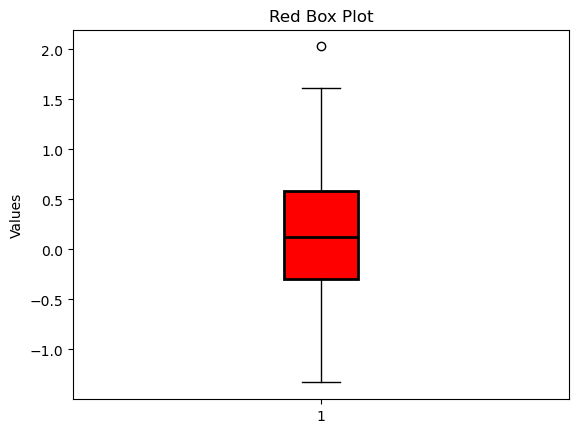

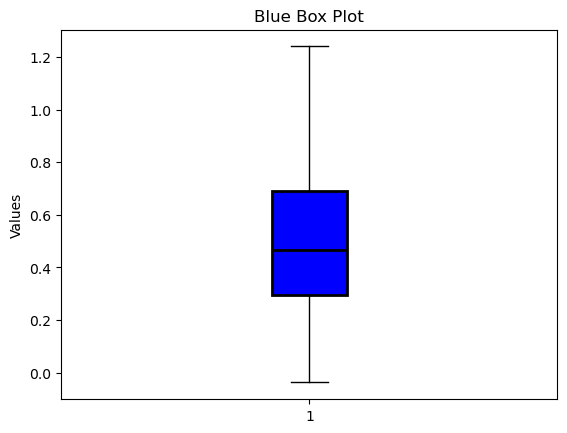

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Create a box plot for the red data
# Plot
fig, ax = plt.subplots()
boxprops = dict(linewidth=2, color='k')  # Border props
medianprops = dict(linewidth=2, color='black')
meanprops = dict(marker='o', markerfacecolor='black', markersize=8)

red_data = np.random.normal(0.3, 0.7, 100)
box = ax.boxplot(red_data, patch_artist=True, boxprops=boxprops, medianprops=medianprops, meanprops=meanprops, showmeans=False)

# Set the color of the box plot
for patch in box['boxes']:
    patch.set_facecolor('red')

# Set the title and labels
ax.set_title('Red Box Plot')
ax.set_ylabel('Values')

# Display the plot
plt.show()
# Create a box plot for the blue data
fig, ax = plt.subplots()
blue_data = np.random.normal(0.5, 0.3, 100)
box = ax.boxplot(blue_data, patch_artist=True, boxprops=boxprops, medianprops=medianprops, meanprops=meanprops, showmeans=False)

# Set the color of the box plot
for patch in box['boxes']:
    patch.set_facecolor('blue')

# Set the title and labels
ax.set_title('Blue Box Plot')
ax.set_ylabel('Values')

# Display the plot
plt.show()

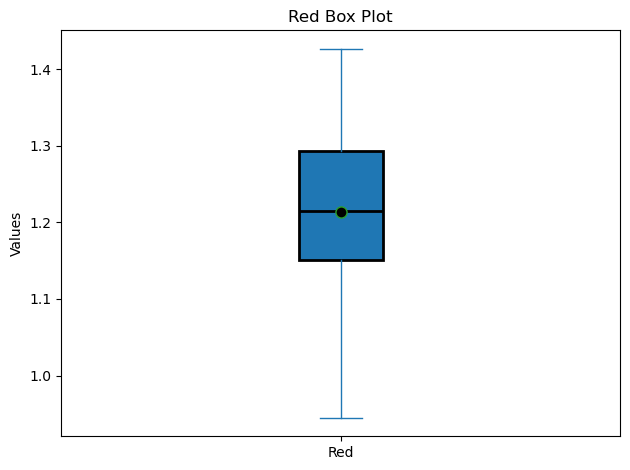

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generate synthetic faulty dataset
np.random.seed(0)
red_data = np.random.normal(1.2, 0.1, 50)  # Faulty data (red)

# Combine data into a DataFrame
data = pd.DataFrame({
    "Red Fault": red_data
})

# Plot
fig, ax = plt.subplots()
boxprops = dict(linewidth=2, color='k')  # Border props
medianprops = dict(linewidth=2, color='black')
meanprops = dict(marker='o', markerfacecolor='black', markersize=8)

# Boxplot with red color
box = data[['Red Fault']].plot(
    kind='box',
    color=dict(boxes=['red']),
    patch_artist=True,  # Fill boxes
    showmeans=True,
    medianprops=medianprops,
    boxprops=boxprops,
    meanprops=meanprops,
    ax=ax
)

# Customize plot
plt.title("Red Box Plot")
plt.xticks([1], ['Red'])
plt.ylabel("Values")
plt.grid(False)
plt.tight_layout()
plt.show()
